# Using Atlite to retrieve historical data and conversion to power generation potentials for South Africa's Renewable Energy Development Zones

This jupyter notebook documents how to retrieve historical weather data from Atlite and through a cutout and consequently gnerate profiles for wind and solar PV. The notebook is based on generation potentials for South Africa's Renewable Energy Development Zones (REDZs). Links are provided to download shape files for the REDZs provided at the Department of Forestry, Fisheries and the Environment of the Republic of South Africa. 

- Atlite is documented in https://joss.theoj.org/papers/10.21105/joss.03294
- Atlite tutorials are documented in https://github.com/PyPSA/atlite/tree/master/examples 
- Renewable Energy Development Zones (REDZs) shape files are located at https://egis.environment.gov.za/data_egis/data_download/current. A user profile is to be created before downloading the shape files.

Inputs:
- Shape file
    - Phase 1 and Phase 2 REDZs shape files from https://egis.environment.gov.za/data_egis/data_download/ 

Outputs:
- A cutout with spatio-temporal bounds given by extent of the REDZs at hourly intervals for the year 2013
- Cutout contains 


The dependencies required to read the shape files into geo pandas data frames are imported together with the atlite module.

In [95]:
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import xarray as xr
import atlite

from shapely.ops import unary_union

## Reading REDZs shape file

Download and unzip the files Phase1_REDZs.zip and Phase2_REDZs.zip from https://egis.environment.gov.za/data_egis/data_download/ .

The shape files have extension .shp and can be read into the jupyter notebook using geo pandas

In [104]:
REDZ_shapefile_1 = gpd.read_file('/home/bubbles/Downloads/REDZs.shp')
REDZ_shapefile_2 = gpd.read_file('/home/bubbles/Downloads/PHASE 2_REDZs.shp')

2022-09-06 13:10:24,919 INFO Failed to auto identify EPSG: 7


The first shape file REDZ_shapefile_1 gives the 8 REDZs identified in Phase 1 while the second shape file REDZ_shapefile_1 gives 3 additional REDZs identified in Phase 2. The Phase 1 shape file is projected to a coordinate reference system 'epsg:32635' and then to 'epsg:4326' using the to_crs().

In [105]:
REDZ_shapefile_1 = REDZ_shapefile_1.to_crs('epsg:32635')

To do a a single cutout using atlite which covers all the REDZs we create a geo data frame using geo pandas of the concatenated shape files. The shape files have different information so values with NAN are removed 

In [173]:
unified_redz_shape = pd.concat([REDZ_shapefile_1.to_crs('epsg:4326'),REDZ_shapefile_2])

REDZ = gpd.GeoDataFrame(unified_redz_shape)
#REDZ = REDZ["geometry"][REDZ["geometry"].is_valid]

REDZ = gpd.GeoDataFrame(REDZ).set_index(REDZ.Name)
REDZ = REDZ.rename(columns={0: "geometry"}).set_geometry("geometry")

unified_shape_file = unary_union(REDZ["geometry"])
unified_shape = gpd.GeoDataFrame(geometry=[unified_shape_file],crs=4326)

## Create a cutout with spatio-temporal bounds given by extent of the REDZs

Determine the extent of the cutout by determining the bounds of the unified_shape created above. Use the geographical bounds as input to the cutout

In [174]:

bounds = unified_shape.unary_union.bounds
cutout = atlite.Cutout(path="/home/bubbles/atliteCutOuts/redz-2012-1.nc", # name of file to save cutout
                       module="era5", # database
                       bounds=bounds, # geographical bounds incusing all 27 regions
                       time=slice('2012-01-01', '2013-01-01')) # January 2011

/home/bubbles/anaconda3/lib/python3.9/site-packages/atlite/cutout.py:187: UserWarning: Arguments module, bounds, time are ignored, since cutout is already built.
  warn(


To prepare the cutout follow the exaple given in the atlite documentation especially setting up of the ADS key. Prepare the cutup. This is the time consuming step as all the data from the is retrieved here. 

In [175]:
cutout.prepare()

2022-09-06 13:47:56,736 INFO Cutout already prepared.


<Cutout "redz-2012-1">
 x = 17.00 ⟷ 30.00, dx = 0.25
 y = -34.50 ⟷ -25.50, dy = 0.25
 time = 2012-01-01 ⟷ 2013-01-01, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

The cutout region and the REDZs are plotted following the examples from atlite

/home/bubbles/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


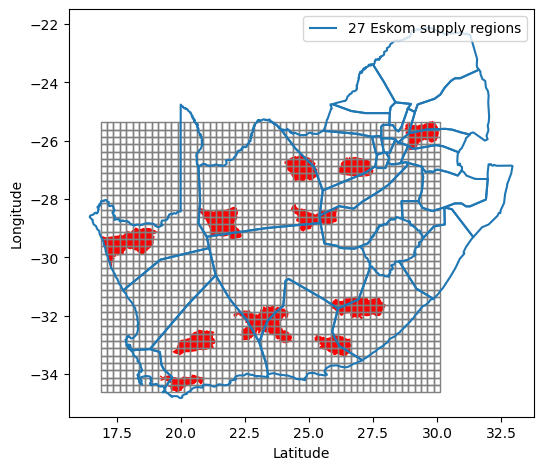

In [186]:
fig, ax = plt.subplots(figsize=(6,6));
unified_shape.plot(ax=ax, label='REDZs',color='Red');
cutout.grid.plot(ax=ax, edgecolor='grey', color='None', label='Cutout geographical bounds');

supply_regions_shapefile = shpreader.Reader('/home/bubbles/pypsa/pypsa-za/data/supply_regions/supply_regions.shp')

supply_regions = gpd.GeoSeries({r.attributes['name']: r.geometry
                      for r in supply_regions_shapefile.records()},
                      crs={'init': 'epsg:4326'}
                     )
supply_regions.boundary.plot(ax=ax, label='27 Eskom supply regions')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend()


In [177]:
# Create exclusion container to exclude SAPAD and SACAD from the shape file. Available area is also
# shown
cap_per_sqkm = 1.7 #

excluder = atlite.ExclusionContainer()
excluder.add_geometry('SACAD_OR_2017_Q2/SACAD_OR_2017_Q2.shp')
excluder.add_geometry('SAPAD_OR_2022_Q1/SAPAD_OR_2022_Q1.shp')


availability_matrix = cutout.availabilitymatrix(REDZ.to_crs(excluder.crs),excluder)

area = cutout.grid.to_crs(3035).area / 1e6
area = xr.DataArray(area.values.reshape(cutout.shape),
                        [cutout.coords['y'], cutout.coords['x']])
potential = availability_matrix * area * cap_per_sqkm

capacity_factor = cutout.pv(panel='CSi', orientation='latitude_optimal',capacity_factor=True)
layout = capacity_factor * area * cap_per_sqkm


Compute availability matrix: 100%|██████████| 11/11 [00:55<00:00,  5.07s/ gridcells]
2022-09-06 13:49:13,836 INFO Convert and aggregate 'pv'.


[########################################] | 100% Completed | 9.88 s


In [178]:
# Prepare the cut-out. Commented out as cutout is already downloaded.
#cutout.prepare()

profile_pv, capacities_pv = cutout.pv(panel='CSi', orientation='latitude_optimal',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout, index=REDZ.index,
                                per_unit=True, return_capacity=True)



2022-09-06 13:49:33,898 INFO Convert and aggregate 'pv'.


[########################################] | 100% Completed | 10.51 s


array([[<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
        <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
        <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
        <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
        <AxesSubplot:xlabel='time'>]], dtype=object)

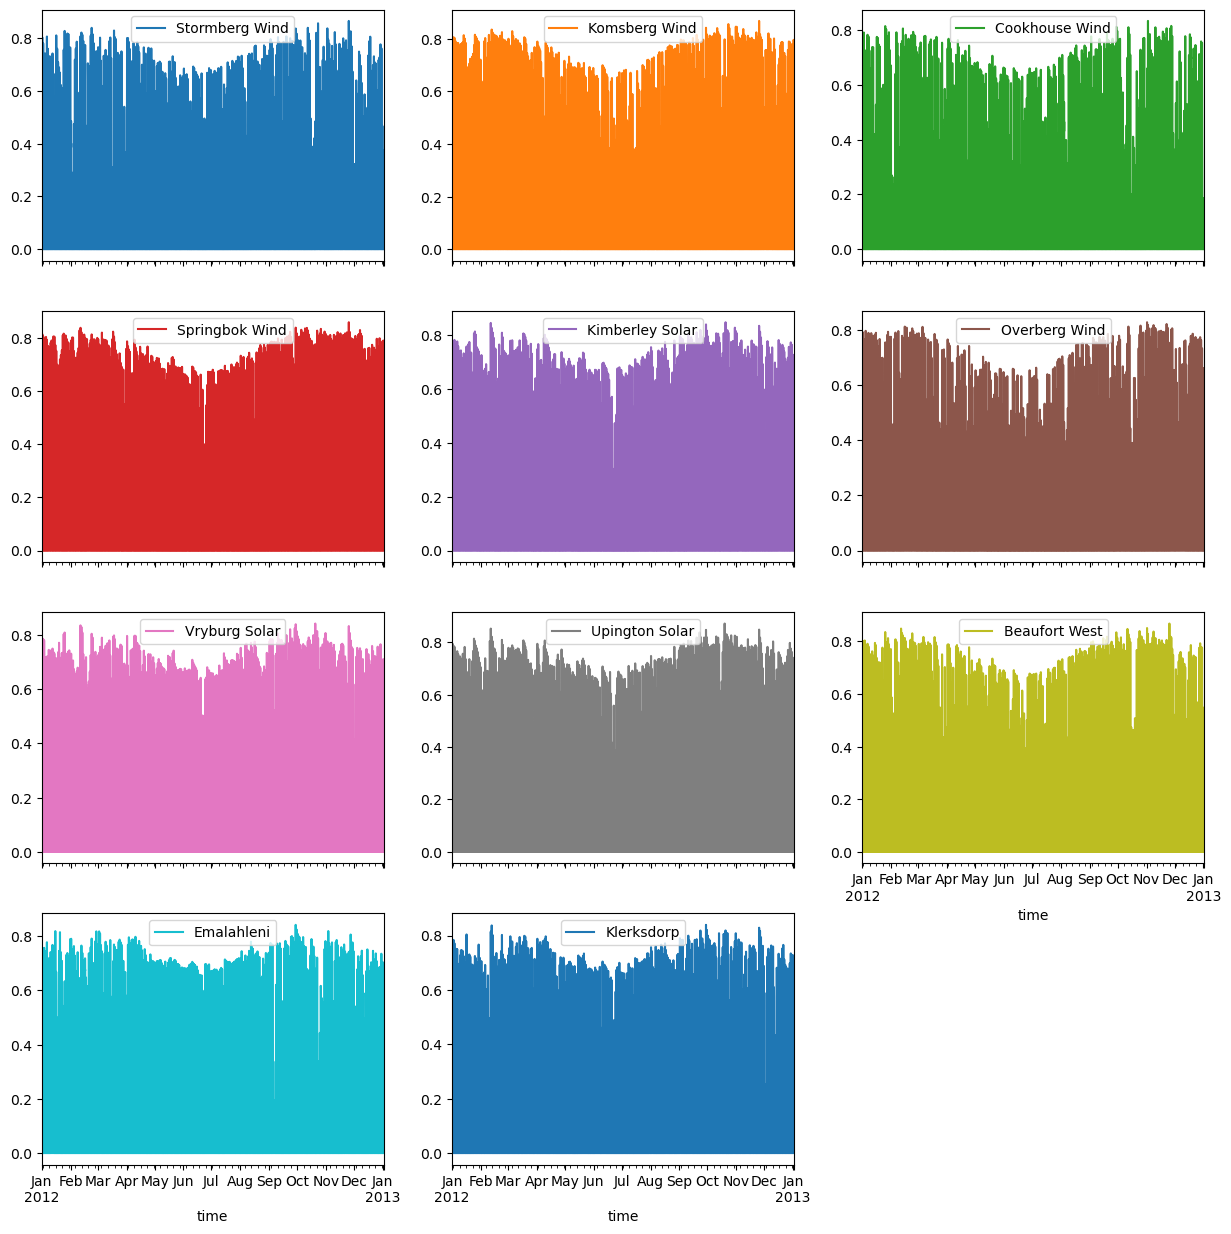

In [179]:
profile_pv.to_pandas().plot(subplots=True, layout=(4,3),figsize=(15, 15))


## Some plotting with Atlite

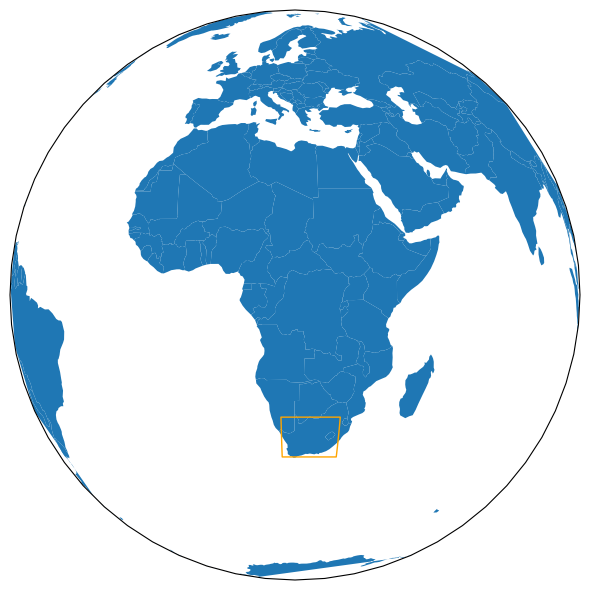

In [194]:
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate

projection = ccrs.Orthographic(20, 0)
cells = cutout.grid
df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_bound = gpd.GeoSeries(cells.unary_union)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(6, 6))
df.plot(ax=ax, transform=plate())
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
fig.tight_layout()

/tmp/ipykernel_5437/4260813612.py:13: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')


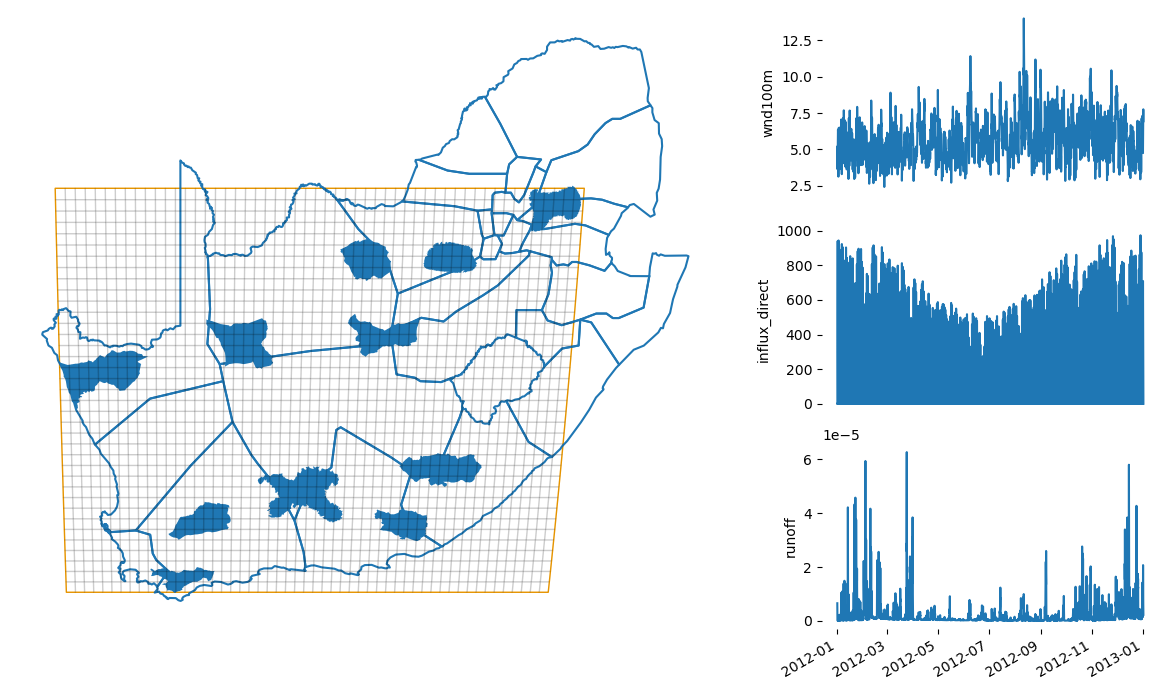

In [199]:
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
country_bound.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
ax.outline_patch.set_edgecolor('white')
REDZ.plot(ax=ax, zorder=1, transform=plate())
supply_regions.boundary.plot(ax=ax, zorder=1, transform=plate())
ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(['x', 'y']).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_xlabel(None)
fig.tight_layout()

In [205]:
cutout.data.prepared_features

['wind', 'influx', 'runoff', 'height', 'temperature']

/tmp/ipykernel_5437/3417711259.py:13: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')
2022-09-06 15:13:36,803 INFO Convert and aggregate 'wind'.
/home/bubbles/anaconda3/lib/python3.9/site-packages/atlite/gis.py:143: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(orig)


[########################################] | 100% Completed | 2.40 s


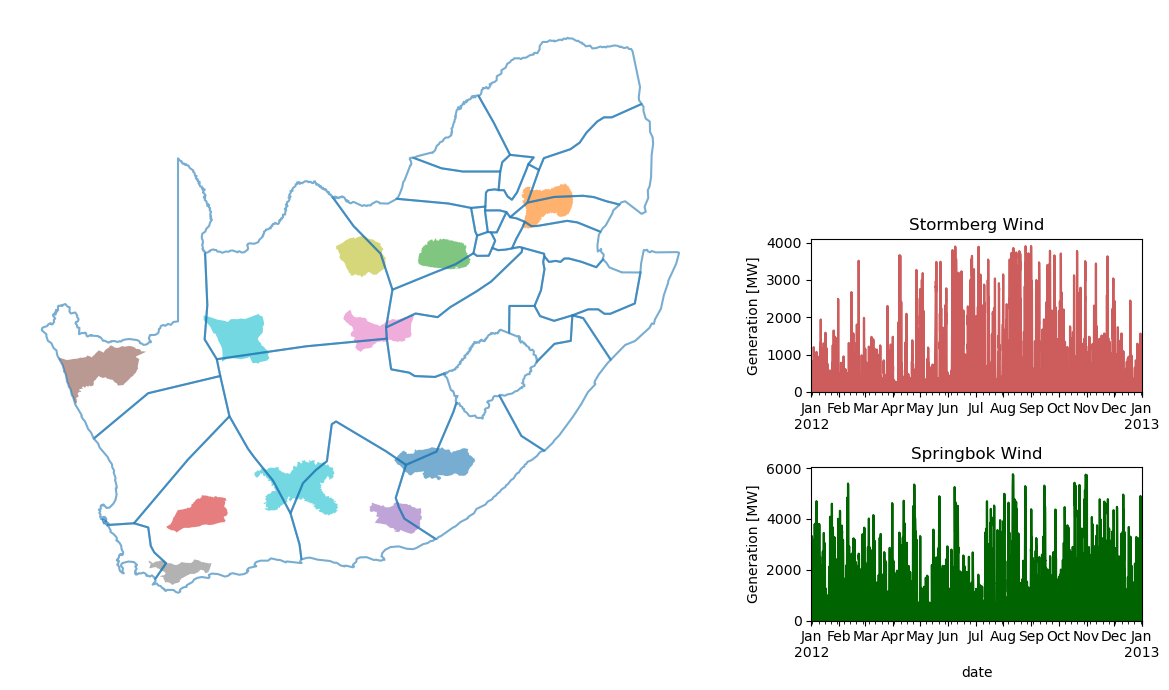

In [211]:
from shapely.geometry import Point

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
df = gpd.GeoDataFrame(REDZ, columns=['geometry']).assign(color=['1', '2','3','4','5','6','7','8','9','10','11'])
df.plot(column='color', ax=ax, zorder=1, transform=plate(), alpha=0.6)
supply_regions.boundary.plot(ax=ax, zorder=1, transform=plate(), alpha=0.6)
#sites.assign(geometry=sites.apply(lambda ds: Point(ds.x, ds.y), axis=1)
#             ).plot(ax=ax, zorder=2, transform=plate(), color='indianred')

ax.outline_patch.set_edgecolor('white')

power_generation = cutout.wind('Vestas_V112_3MW', layout=layout.fillna(0), shapes=REDZ
                               ).to_pandas().rename_axis(index='', columns='shapes')

ax1 = fig.add_subplot(gs[1, 2])
power_generation['Stormberg Wind'].plot.area(
    ax=ax1, title='Stormberg Wind', color='indianred')
ax2 = fig.add_subplot(gs[2, 2])
power_generation['Springbok Wind'].plot.area(
    ax=ax2, title='Springbok Wind', color='darkgreen')

ax2.set_xlabel('date')
[ax.set_ylabel('Generation [MW]') for ax in [ax1,ax2]]
fig.tight_layout()

/tmp/ipykernel_5437/4182412921.py:13: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')
2022-09-06 15:17:18,387 INFO Convert and aggregate 'pv'.


[########################################] | 100% Completed | 13.46 s


2022-09-06 15:17:33,502 INFO Convert and aggregate 'wind'.
/home/bubbles/anaconda3/lib/python3.9/site-packages/atlite/gis.py:143: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(orig)


[########################################] | 100% Completed | 2.27 s


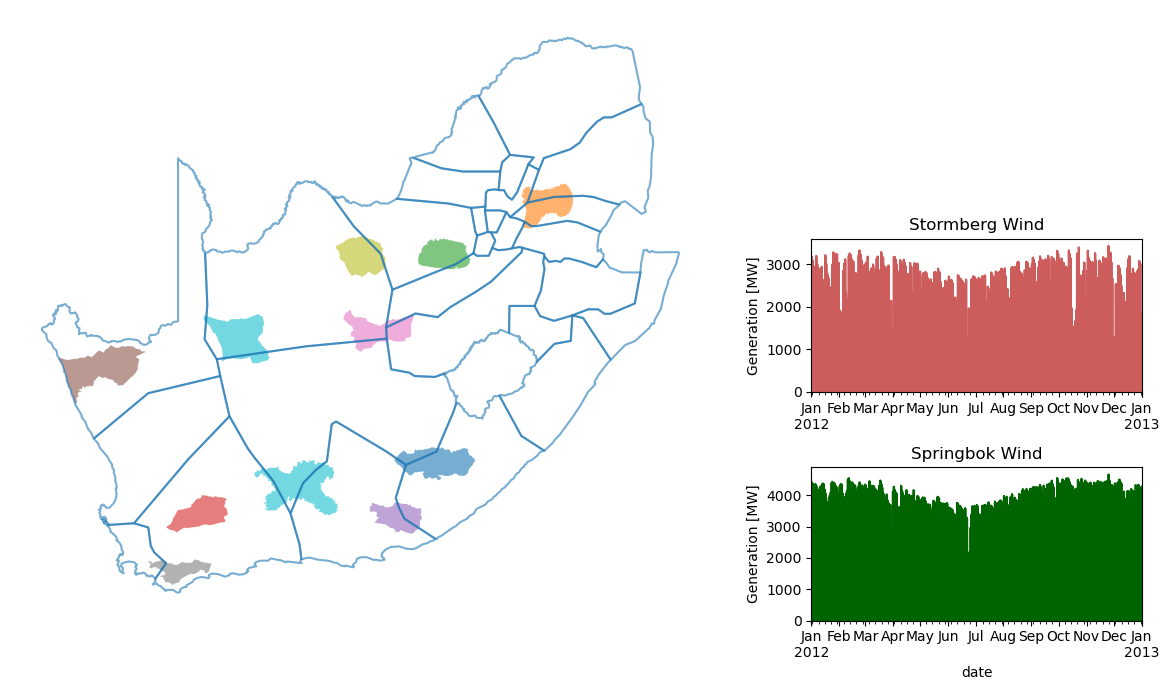

In [212]:
from shapely.geometry import Point

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
df = gpd.GeoDataFrame(REDZ, columns=['geometry']).assign(color=['1', '2','3','4','5','6','7','8','9','10','11'])
df.plot(column='color', ax=ax, zorder=1, transform=plate(), alpha=0.6)
supply_regions.boundary.plot(ax=ax, zorder=1, transform=plate(), alpha=0.6)
#sites.assign(geometry=sites.apply(lambda ds: Point(ds.x, ds.y), axis=1)
#             ).plot(ax=ax, zorder=2, transform=plate(), color='indianred')

ax.outline_patch.set_edgecolor('white')

power_generation_1 = cutout.pv(panel='CSi', orientation='latitude_optimal',matrix=availability_matrix.stack(spatial=['y','x']),
                                layout=layout.fillna(0), index=REDZ.index).to_pandas().rename_axis(index='', columns='shapes')
power_generation = cutout.wind('Vestas_V112_3MW', layout=layout.fillna(0), shapes=REDZ
                               ).to_pandas().rename_axis(index='', columns='shapes')

ax1 = fig.add_subplot(gs[1, 2])
power_generation_1['Stormberg Wind'].plot.area(
    ax=ax1, title='Stormberg Wind', color='indianred')
ax2 = fig.add_subplot(gs[2, 2])
power_generation_1['Springbok Wind'].plot.area(
    ax=ax2, title='Springbok Wind', color='darkgreen')

ax2.set_xlabel('date')
[ax.set_ylabel('Generation [MW]') for ax in [ax1,ax2]]
fig.tight_layout()

2022-09-06 15:21:23,778 INFO Convert and aggregate 'wind'.


[########################################] | 100% Completed | 2.87 s


/tmp/ipykernel_5437/2039804399.py:8: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')


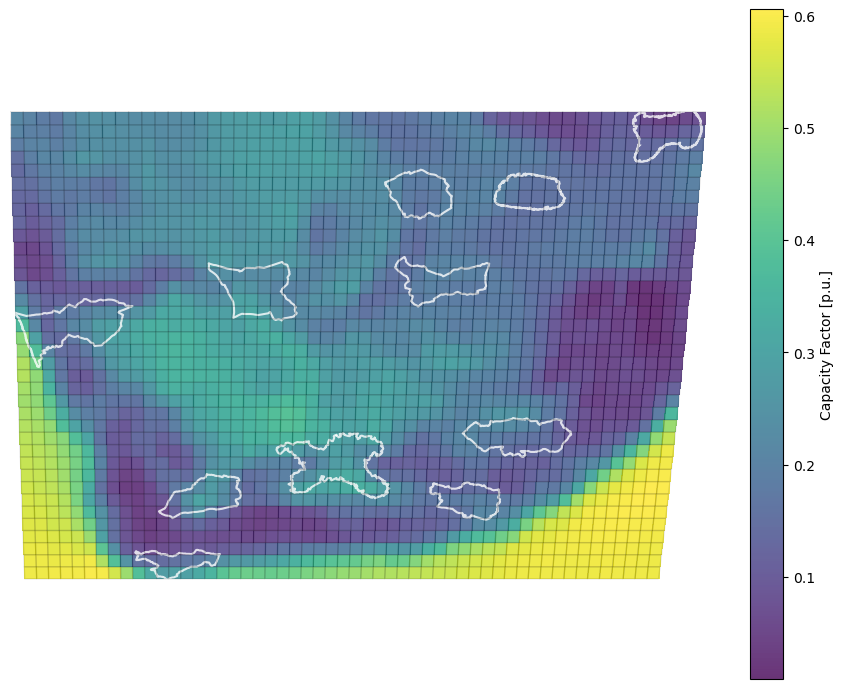

In [215]:
cap_factors = cutout.wind(turbine='Vestas_V112_3MW', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

2022-09-06 15:23:58,285 INFO Convert and aggregate 'pv'.


[########################################] | 100% Completed | 11.71 s


/tmp/ipykernel_5437/3279224580.py:8: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')


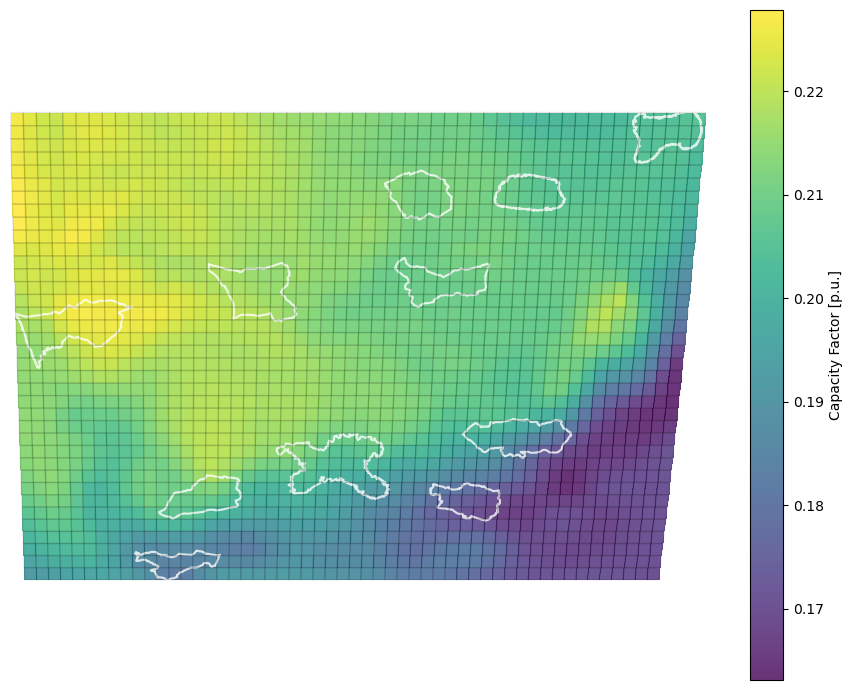

In [217]:
cap_factors = cutout.pv(panel='CSi', orientation='latitude_optimal', capacity_factor=True)

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
REDZ.boundary.plot(ax=ax, transform=plate(), alpha=0.8,color='white')
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

In [219]:
cutout.wind(turbine='x', smooth=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/bubbles/anaconda3/lib/python3.9/site-packages/atlite/resources/windturbine/x.yaml'